In [1]:
import numpy as np 
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from load_IUCN_data import load_IUCN_data

# Web scraped data

In [2]:
# load Data
df = load_IUCN_data()

In [3]:
df.head()

,class,common_name,scientific_name,trend,region,threat_level,country
0,mammalia,Brown Bear,Ursus arctos,Stable,Global,Least Concern,United Kingdom
1,mammalia,Greater Mouse-eared Bat,Myotis myotis,Stable,Global,Least Concern,United Kingdom
2,actinopterygii,Atlantic sturgeon,Acipenser sturio,Decreasing,"Global, Europe",Critically Endangered,United Kingdom
3,mammalia,Wild Boar,Sus scrofa,Unknown,Global,Least Concern,United Kingdom
4,mammalia,Gray Whale,Eschrichtius robustus,Stable,Global,Least Concern,United Kingdom


In [16]:
# fill nan vlaues in trend with existing Unknown
df.trend.fillna('Unknown', inplace=True)

<AxesSubplot:>

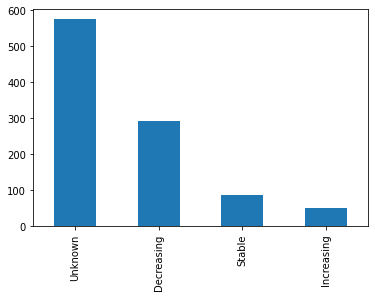

In [20]:
df.trend.value_counts().plot(kind='bar')

## Data cleaning

For the threat_level some datapoints are missing. We checked the species directly on the webpage.
There is no value for is and so and we use 'Data Deficient' for these.

In [21]:
df.threat_level.unique()

array(['Least Concern', 'Critically Endangered', 'Near Threatened',
       'Extinct', 'Vulnerable', 'Endangered', 'Extinct in the Wild',
       'Data Deficient'], dtype=object)

In [22]:
# missing data on web search
# give "[missing "en.shared.categories.cd" translation]" 'Data Deficient" label
df.threat_level.replace({'[missing "en.shared.categories.cd" translation]': 'Data Deficient'}, inplace=True)

# Inspect species

In [39]:
# number of animal species in OECD countrys
df.scientific_name.unique().shape[0]

754

In [44]:
species = df.drop(columns=['country']).drop_duplicates()
species.shape

(754, 6)

In [45]:
species.head()

,class,common_name,scientific_name,trend,region,threat_level
0,mammalia,Brown Bear,Ursus arctos,Stable,Global,Least Concern
1,mammalia,Greater Mouse-eared Bat,Myotis myotis,Stable,Global,Least Concern
2,actinopterygii,Atlantic sturgeon,Acipenser sturio,Decreasing,"Global, Europe",Critically Endangered
3,mammalia,Wild Boar,Sus scrofa,Unknown,Global,Least Concern
4,mammalia,Gray Whale,Eschrichtius robustus,Stable,Global,Least Concern


<AxesSubplot:xlabel='class'>

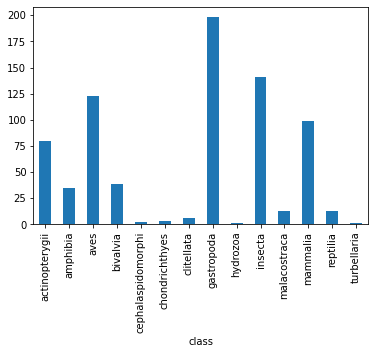

In [50]:
# species per class in OECD countrys
species_per_class = species.groupby('class')['scientific_name'].count()
species_per_class.plot(kind="bar")

# Create data for species per trend per country

In [26]:
# transform data
grouped = df.groupby(['country', 'trend'])['scientific_name'].count().reset_index(name='count')
species_trend_country = grouped.pivot(index='country', columns='trend', values='count')
species_trend_country = species_tl_country.fillna(0.0)
species_trend_country.shape

(29, 4)

In [27]:
species_trend_country.head()

trend,Decreasing,Increasing,Stable,Unknown
country,,,,
Australia,5.0,0.0,1.0,5.0
Austria,12.0,3.0,3.0,3.0
Belgium,9.0,1.0,1.0,0.0
Canada,6.0,0.0,2.0,3.0
Czech Republic,9.0,1.0,4.0,5.0


## Create data for species per threat level per country

In [7]:
# check for missing values
df.isna().sum()

class                0
common_name        314
scientific_name      0
trend              427
region               0
threat_level         0
country              0
dtype: int64

In [28]:
# transform data
grouped = df.groupby(['country', 'threat_level'])['scientific_name'].count().reset_index(name='count')
species_tl_country = grouped.pivot(index='country', columns='threat_level', values='count')
species_tl_country = species_tl_country.fillna(0.0)

In [29]:
species_tl_country.head()

threat_level,Critically Endangered,Data Deficient,Endangered,Extinct,Extinct in the Wild,Least Concern,Near Threatened,Vulnerable
country,,,,,,,,
Australia,6.0,0.0,0.0,42.0,0.0,3.0,1.0,1.0
Austria,7.0,0.0,0.0,3.0,0.0,8.0,2.0,4.0
Belgium,2.0,0.0,1.0,1.0,0.0,6.0,1.0,3.0
Canada,5.0,1.0,1.0,9.0,0.0,4.0,1.0,3.0
Czech Republic,2.0,3.0,0.0,0.0,0.0,11.0,3.0,1.0


This DataFrames include the same data as the "Table 6a" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.

## Create data for species per class per country

In [90]:
# transform data
grouped = df.groupby(['country', 'class'])['scientific_name'].count().reset_index(name='count')
species_class_country = grouped.pivot(index='country', columns='class', values='count')
species_class_country = species_class_country.fillna(0.0)

In [93]:
species_class_country.head()

class,actinopterygii,amphibia,aves,bivalvia,cephalaspidomorphi,chondrichthyes,clitellata,gastropoda,hydrozoa,insecta,malacostraca,mammalia,reptilia,turbellaria
country,,,,,,,,,,,,,,
Australia,1.0,5.0,11.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,1.0,27.0,0.0,1.0
Austria,4.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,4.0,0.0,5.0,1.0,0.0
Belgium,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,4.0,0.0,0.0
Canada,5.0,0.0,4.0,1.0,0.0,0.0,0.0,5.0,0.0,3.0,0.0,3.0,3.0,0.0
Czech Republic,2.0,0.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,3.0,0.0,0.0


This DataFrames include the same data as the "Table 5" and makes not that much sense to use but we could use this to check if the data on the webpage is reasonable or if ther has gone something wrong when web scraping.